In [0]:
from fastai import *
from fastai.vision import *

## Object Detection 
Next, we'll take a look at an object detection. `fastai` provides a `ObjectItemList` class for creating a `databunch` for this task. However, similar to the previous dataset this one also has some caveats that we will explore. 


### X-Ray Images
`fastai` uses `PIL` to open images from files and then turns them into `pytorch` tensors. X-Ray images are stored as [dicom](https://pydicom.github.io/pydicom/stable/getting_started.html) files and `PIL` cannot open them. So we will try to overwrite the `open_image` (for starters) function in `fastai` and create `databunch` for an object detection task. The task here will be detecting and localizing pneumonia from x-rays.
The data can be downloaded from the kaggle challenge [here](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data).

### Downloading Kaggle datasets into Colab
First you want to get your kaggle api credentials from your kaggle account then install the kaggle api 
```
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload() #upload the kaggle.json file that you got from your account
!cp kaggle.json ~/.kaggle/
```
Once you have this setup you can download datasets using the api:
`!kaggle competitions download -c rsna-pneumonia-detection-challenge`

In [0]:
#!echo '{"username":"username","key":"key"}' > ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 39.8MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 50.4MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 88.2MB/s]
 95% 360M/377M [00:03<00:00, 119MB/s] 
100% 377M/377M [00:04<00:00, 92.2MB/s]
100% 3.29G/3.29G [00:27<00:00, 79.8MB/s]
100% 3.29G/3.29G [00:27<00:00, 128MB/s] 
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 48.6kB/s]


In [0]:
!mkdir stage_2_train_images
!unzip stage_2_train_images.zip -d stage_2_train_images
!unzip stage_2_train_labels.csv.zip
!unzip stage_2_detailed_class_info.csv.zip

In [2]:
path = Path('.')
path.ls() 

[PosixPath('.config'),
 PosixPath('GCP%20Credits%20Request%20Link%20-%20RSNA.txt'),
 PosixPath('stage_2_train_labels.csv'),
 PosixPath('stage_2_detailed_class_info.csv.zip'),
 PosixPath('stage_2_detailed_class_info.csv'),
 PosixPath('stage_2_train_images'),
 PosixPath('stage_2_train_images.zip'),
 PosixPath('stage_2_train_labels.csv.zip'),
 PosixPath('stage_2_sample_submission.csv'),
 PosixPath('stage_2_test_images.zip'),
 PosixPath('kaggle.json'),
 PosixPath('sample_data')]

In [0]:
TRAIN_IMG = path/'stage_2_train_images'
TRAIN_LABEL = path/'stage_2_train_labels.csv'

In [0]:
#!pip install pydicom
import pydicom
from matplotlib import cm
from matplotlib import pyplot as plt

In [5]:
df = pd.read_csv(TRAIN_LABEL)
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
def show_dcm_info(file):
    ##read a dicom file and print some info
    print("Filename.........:", path/file.PatientID)
    print("Storage type.....:", file.SOPClassUID)
    print()

    pat_name = file.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", file.PatientID)
    print("Patient's Age.......:", file.PatientAge)
    print("Patient's Sex.......:", file.PatientSex)
    print("Modality............:", file.Modality)
    print("Body Part Examined..:", file.BodyPartExamined)
    print("View Position.......:", file.ViewPosition)
    
    if 'PixelData' in file:
        rows = int(file.Rows)
        cols = int(file.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(file.PixelData)))
        if 'PixelSpacing' in file:
            print("Pixel spacing....:", file.PixelSpacing)

In [0]:
def show_img(file, figsize=(10,10)):
    #plot the image using matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(file.pixel_array, cmap=plt.cm.bone)
    plt.show()


Filename.........: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, 
Patient id..........: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Patient's Age.......: 51
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 142006 bytes
Pixel spacing....: ['0.14300000000000002', '0.14300000000000002']


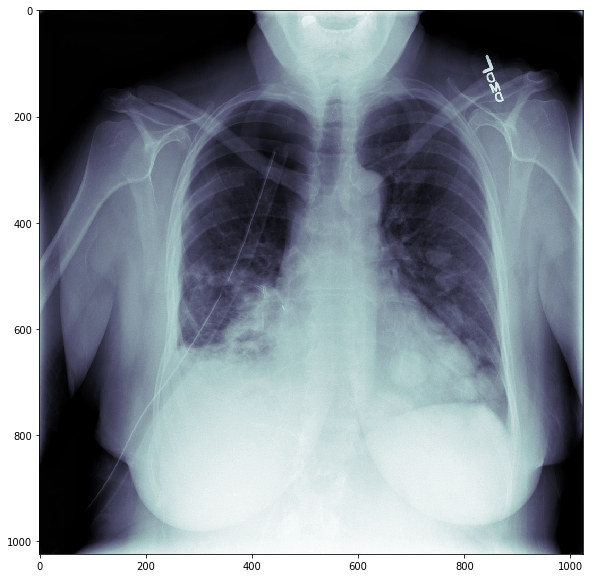

In [14]:
# Lets take a look at one x-ray
file_path = str(TRAIN_IMG/(df.iloc[0]['patientId']+'.dcm'))
file = pydicom.dcmread(file_path)
show_dcm_info(file)
show_img(file)

In [0]:
tfms = get_transforms(do_flip=False,flip_vert=False,max_lighting=0)

In [0]:
open_image??

In [0]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        #custom open
        dicom_arr = pydicom.dcmread(str(fn)).pixel_array
        x = PIL.Image.fromarray(dicom_arr).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

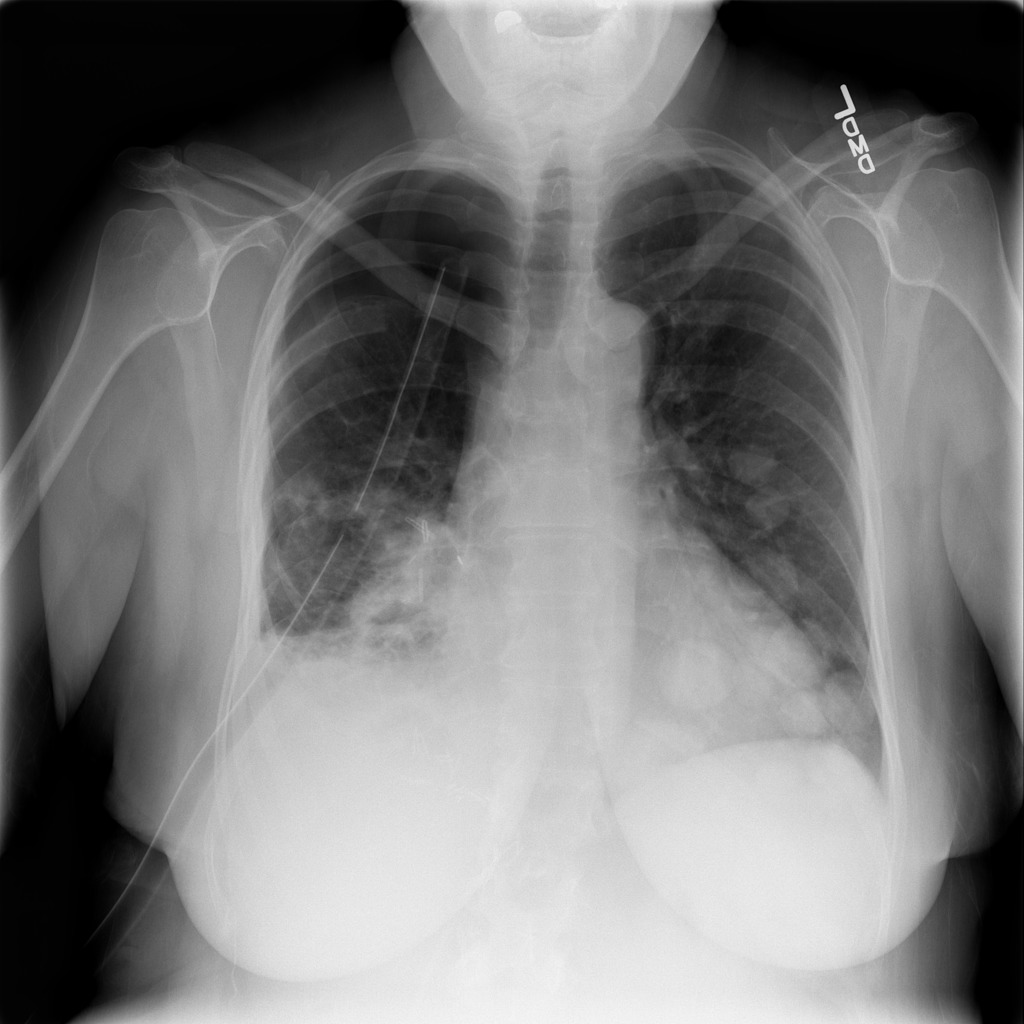

In [0]:
open_image(file_path)

In [0]:
ImageList??

In [0]:
class DicomItemList(ImageList):
    ## overwrite the open func in ImageList
    def open(self, fn): return open_image(fn)

In [0]:
data = (DicomItemList.from_df(df.head(100),TRAIN_IMG,cols='patientId',suffix='.dcm')
                 .split_by_rand_pct()
                 .label_from_df('Target')
                 .transform(tfms)
                 .databunch(bs=6))

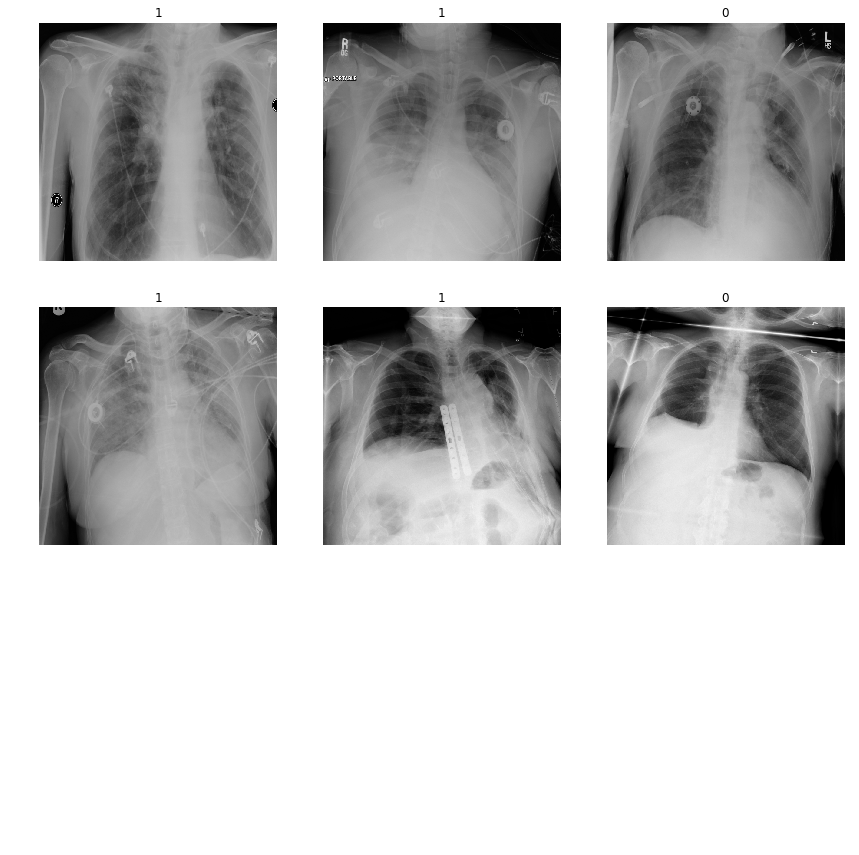

In [15]:
data.show_batch()

Now that we've learned how to open these images, next step would be to use bounding boxes to localize the areas with pneumonia.

In [0]:
ObjectItemList??

In [0]:
class DicomItemList(ObjectItemList):
    def open(self, fn): return open_image(fn)

In [12]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [19]:
detailed_df = pd.read_csv(path/'stage_2_detailed_class_info.csv')
detailed_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


We have two different `csv` files to look through. The first one contains the bounding boxes and the second one contains the class values. `fastai` expects the filename of the image as the `x` value and `bboxes,class` tuple as the `y` value. `bboxes,class` are lists of bounding boxes (`[[x1,y1,width1,height1],[x2,y2,width2,height2]...]`) and their corresponding class labels (`[class1,class2..]`)

In [0]:
def get_bbox_df(df, detailed_df):
    #get all bboxes and classes from dataframe
    df['duplicate'] = df.duplicated(['patientId'], keep=False)
    class_df = df.merge(detailed_df, on="patientId")
    mb_df = class_df.filter(['patientId', 'x','y','width','height'])
    
    #replace na values with the the entire image as the bbox
    na_values = {'x': 0, 'y': 0, 'width': 1024, 'height': 1024}
    mb_df = mb_df.fillna(na_values)
    
    #combine bboxes into a single string 'x1 y1 width1 height1 x2 y2 width2 height2 ...'
    mb_df['combined']=mb_df['x'].astype(str)+' '+mb_df['y'].astype(str)+' '+mb_df['width'].astype(str)+' '+mb_df['height'].astype(str)
    mb_df.drop_duplicates(subset=['patientId', 'combined'], inplace=True) 
    mb_df = mb_df.groupby('patientId').agg(lambda x: ' '.join((x)))
    
    #add target and class column to the dataframe
    targ_df = class_df.filter(['patientId','Target','class'])
    targ_df.drop_duplicates(subset=['patientId', 'Target'],inplace=True)
    mb_df = mb_df.merge(targ_df, on='patientId')
    
    #set partientId as index
    #mb_df.set_index('patientId',inplace=True)
    
    return mb_df

In [21]:
mb_df = get_bbox_df(df,detailed_df)
mb_df.head()

,patientId,combined,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0 0.0 1024.0 1024.0,0,No Lung Opacity / Not Normal
1,000924cf-0f8d-42bd-9158-1af53881a557,0.0 0.0 1024.0 1024.0,0,Normal
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0 318.0 170.0 478.0 660.0 375.0 146.0 402.0,1,Lung Opacity
3,000fe35a-2649-43d4-b027-e67796d412e0,570.0 282.0 269.0 409.0 83.0 227.0 296.0 438.0,1,Lung Opacity
4,001031d9-f904-4a23-b3e5-2c088acd19c6,66.0 160.0 373.0 608.0 552.0 164.0 376.0 676.0,1,Lung Opacity


In [0]:
row = mb_df[mb_df['patientId'] == '0004cfab-14fd-4e49-80ba-63a80b6bddd6'].values

In [23]:
row[0][1]

'0.0 0.0 1024.0 1024.0'

In [0]:
def get_bb_label(fn):
    #get labels from the dataframe in the format bboxes-->list,targets-->list
    fn = fn.replace(str(TRAIN_IMG)+'/','').replace('.dcm','')
    row = mb_df[mb_df['patientId'] == fn].values[0]
    bboxes = row[1].split(' ')
    bboxes = [float(o) for o in bboxes]
    bboxes = [bboxes[i:i+4] for i in range(0,len(bboxes),4)]
    targets = row[-1]
    return bboxes,[targets]*len(bboxes)
    #return ','.join(str(o) for o in row[1:])

In [0]:
data = (DicomItemList.from_df(mb_df,TRAIN_IMG,cols='patientId',suffix='.dcm')
                    .split_by_rand_pct()
                    .label_from_func(get_bb_label)
                    .transform(tfms)
                    .databunch(bs=1,collate_fn=bb_pad_collate))

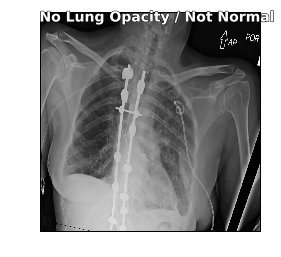

In [26]:
data.show_batch()

`fastai` doesn't yet provide an out-of-the-box Retina Net implementation yet. But probably it will be covered in part 2 of course-v3. Meanwhile, a few of people have come up with their own little models like in this [thread](https://forums.fast.ai/t/object-detection-in-fast-ai-v1/29266/10). We recommend you take a look at some examples and try to re-implement them in your own way.

In [0]:
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

In [0]:
class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

In [0]:
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [conv_layer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [30]:
torch.arange(0,16).long().view(4,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

In [0]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

In [0]:
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

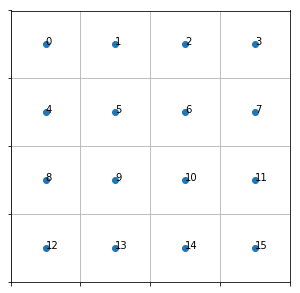

In [33]:
size = (4,4)
show_anchors(create_grid(size), size)

In [0]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [0]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
#Paper used [1,2**(1/3), 2**(2/3)] but a bigger size (600) too, so the largest feature map gave anchors that cover less of the image.
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)

In [36]:
anchors.size()

torch.Size([3069, 4])

In [0]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [0]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

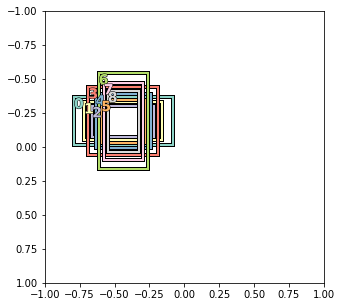

In [39]:
show_boxes(anchors[900:909])

In [0]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [0]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = torch.randn(size[0]*size[1], 4) * 0.1
bboxes = activ_to_bbox(activations, anchors)

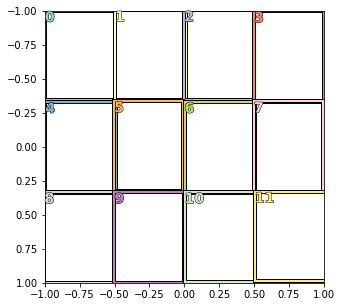

In [42]:
show_boxes(bboxes)

In [0]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [0]:
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

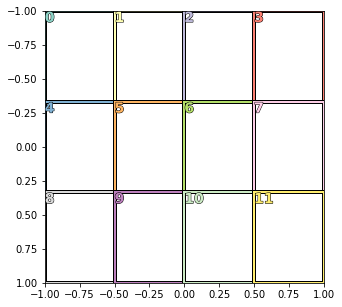

In [45]:
show_boxes(anchors)

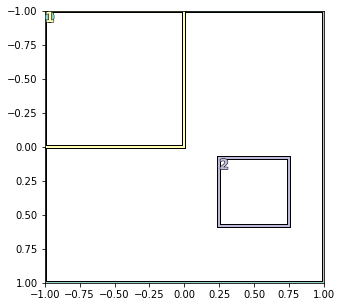

In [46]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [47]:
intersection(anchors, targets)

tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [0]:
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [49]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

In [0]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

In [51]:
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [52]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [53]:
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

In [0]:
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

In [0]:
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [0]:
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [57]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [0]:
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

In [0]:
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

In [0]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
#scales = [1,2**(1/3), 2**(2/3)] for bigger size

In [0]:
encoder = create_body(models.resnet34, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

In [62]:
torch.sigmoid(tensor([-4.]))

tensor([0.0180])

In [0]:
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [0]:
learn = learn.split(retina_net_split)

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


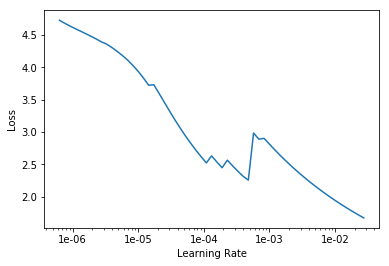

In [66]:
learn.lr_find()
learn.recorder.plot(skip_end=5)

In [0]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,time


In [0]:
learn.save('stage1-128')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 5e-5))
learn.save('stage2-128')

In [0]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = learn.model(img)

In [0]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx